In [160]:
import dask.dataframe as dd
from IPython.display import display
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import binary_dilation
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def log_func(x, a, b, c):
    return a * np.log(x + b) + c

parquet_file_path = 'SimulationResults/UltimateAnalysis/SimulationResults_1748804720/simulation_results_1748804720.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/SimulationResults_1748804720/simulation_results_1748804720.pickle'


with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

ddf = dd.read_parquet(parquet_file_path, engine='pyarrow', 
                      include_partition_columns=True, 
                      gather_statistics=True, 
                      dtype_backend='pyarrow')

parameter_names_used ['Resources', 'Phages']
param_values_list_combination [[100.0, 108.16326530612245, 116.3265306122449, 124.48979591836735, 132.6530612244898, 140.81632653061223, 148.9795918367347, 157.14285714285714, 165.30612244897958, 173.46938775510205, 181.6326530612245, 189.79591836734693, 197.9591836734694, 206.12244897959184, 214.28571428571428, 222.44897959183675, 230.6122448979592, 238.77551020408163, 246.9387755102041, 255.10204081632654, 263.265306122449, 271.42857142857144, 279.59183673469386, 287.7551020408163, 295.9183673469388, 304.0816326530612, 312.2448979591837, 320.40816326530614, 328.57142857142856, 336.734693877551, 344.8979591836735, 353.0612244897959, 361.2244897959184, 369.38775510204084, 377.55102040816325, 385.7142857142857, 393.8775510204082, 402.0408163265306, 410.2040816326531, 418.36734693877554, 426.53061224489795, 434.6938775510204, 442.8571428571429, 451.0204081632653, 459.18367346938777, 467.34693877551024, 475.51020408163265, 483.6734693877551, 49

In [161]:
from joblib import Parallel, delayed

matrix = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
def process_resource(i, resource_value):
    local_matrix = np.zeros(len(pickle_data['param_values_list_combination'][1]))
    local_matrix2 = np.zeros(len(pickle_data['param_values_list_combination'][1]))
    for j, phage_value in enumerate(pickle_data['param_values_list_combination'][1]):
        # print("processing resource", i, "phage", j)
        simulation_results = ddf.query(f'Resources == {resource_value} and Phages == {phage_value}').compute()
        y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[-1, :]
        if np.any(y_values > phage_value * 2):
            local_matrix[j] = np.max(y_values)
            local_matrix2[j] = 1
    print(local_matrix)
    return local_matrix, local_matrix2

results = Parallel(n_jobs=-1)(
    delayed(process_resource)(i, resource_value)
    for i, resource_value in enumerate(pickle_data['param_values_list_combination'][0])
)

for i, (col, col2) in enumerate(results):
    matrix[i, :] = col
    matrix2[i, :] = col2
matrix = matrix.T
matrix2 = matrix2.T

[   0.            0.            0.            0.            0.
    0.         4673.55570607 4784.65275644 4836.99745973 4871.83230163
 4897.76710592 4918.43588522 4935.77745281 4950.5554983  4963.50260328
 4975.0156502  4985.31292724 4994.56273176 5003.36279974 5011.25441315
 5018.62941927 5025.54191999 5031.95325949 5038.02446723 5043.7838842
 5049.05724607 5054.36860773 5059.16415155 5063.83719028 5068.3934732
 5072.56102163 5076.64767518 5080.69959638 5084.44180626 5087.91052836
 5091.61349386 5095.06314619 5098.28234024 5101.30971003 5104.56009352
 5107.6097479  5110.477565   5113.18017152 5115.93058647 5118.70761916
 5121.33445724 5123.82349438 5126.18581616 5128.55506748 5131.0172708 ]
[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.         5321.66062668 5465.01554826 5524.47184876 5562.86453661
 5591.04422653 5613.11777764 5631.80726417 5647.62167396 5661.35229461
 5673.42086236 5684.45411136 56

KeyboardInterrupt: 

/var/folders/gg/_vl162cs4zs99kls4stdr7xc0000gn/T/ipykernel_49494/3452729287.py:13: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


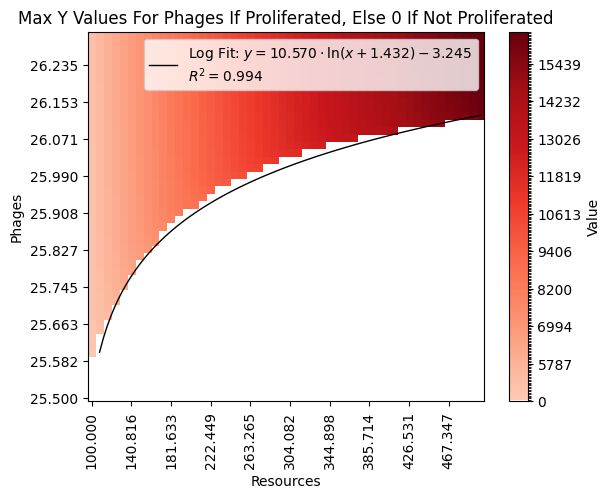

In [ ]:
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.imshow(matrix, aspect='auto', origin='lower', cmap='viridis')

boundary = np.logical_xor(matrix2, binary_dilation(matrix2))
y_coords, x_coords = np.where(boundary)
X = x_coords.reshape(-1, 1)
y = y_coords
mask = x_coords > 0
x_log = x_coords[mask]
y_log = y_coords[mask]
popt, _ = curve_fit(log_func, x_log, y_log, p0=(1, 1, 1), maxfev=10000)
x_fit = np.linspace(x_log.min(), x_log.max(), 100)
y_fit = log_func(x_fit, *popt)
y_pred = log_func(x_log, *popt)
r2 = r2_score(y_log, y_pred)
a, b, c = popt
if c < 0:
    label = f'Log Fit: $y = {a:.3f} \cdot \ln(x + {b:.3f}) {c:.3f}$\n$R^2 = {r2:.3f}$'
else:
    label = f'Log Fit: $y = {a:.3f} \cdot \ln(x + {b:.3f}) + {c:.3f}$\n$R^2 = {r2:.3f}$'
plt.plot(x_fit, y_fit, color='black', linewidth=1, label=label)

# Create a custom colormap: black for 0, red to green for >0
colors = ['white'] + [plt.cm.Reds(i) for i in np.linspace(0.2, 1, 255)]
cmap = ListedColormap(colors)
bounds = [0, 1e-10] + list(np.linspace(matrix[matrix > 0].min(), matrix.max(), 255))
norm = BoundaryNorm(bounds, cmap.N)

plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Value', ax=plt.gca())
plt.imshow(matrix, aspect='auto', origin='lower', cmap=cmap, norm=norm)
plt.xlabel('Resources')
plt.ylabel('Phages')
plt.title('Max Y Values For Phages If Proliferated, Else 0 If Not Proliferated')
xtick_indices = np.arange(0, len(pickle_data['param_values_list_combination'][0]), 5)
xtick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][0])[xtick_indices]]
ytick_indices = np.arange(0, len(pickle_data['param_values_list_combination'][1]), 5)
ytick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][1])[ytick_indices]]
plt.xticks(ticks=xtick_indices, labels=xtick_labels, rotation=90)
plt.yticks(ticks=ytick_indices, labels=ytick_labels)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
# plt.savefig('LatexReport/Images/Plots/Created/PP/phase_portrait_resources_phage_max_phage_proliferate.png', dpi=300, bbox_inches='tight')